In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [2]:
from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
import timeit
from PIL import Image
import numpy as np
import cv2
import lovely_tensors as lt
lt.monkey_patch()

In [3]:
RAW_DATA_DIR = Path.cwd().parent / "data"

In [4]:
preprocess = Compose([
    CustomResize(1024),
    PILToTensor(),
    CustomNormalize()
])

In [5]:
dataset = LabelAnythingDataset(
    {
        "coco": {
            "name": "coco",
            "instances_path": RAW_DATA_DIR / "annotations" / "instances_train2017.json",
            "img_dir": RAW_DATA_DIR / "train2017",
            "preprocess": preprocess,
            "sample_function": "uniform"
        }
    }, {}
)

Loading dataset annotations from /home/raffaele/art/LabelAnything/data/annotations/instances_train2017.json...
[2024-02-29 16:32:57] WARNING - coco.py - load_embeddings is not specified. Assuming load_embeddings=False.


In [6]:
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[2, 8], [4, 4], [8, 2], [16, 1]],
        num_processes=1,
        shuffle=False,
)

In [7]:
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)

In [8]:
(batch, _), _ = next(iter(dataloader))

In [9]:
dataset.categories

{'coco': {1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
  2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
  3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
  4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
  5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
  6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
  7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
  8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
  9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
  10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
  11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
  13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
  14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
  15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
  16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
  17: {'supercategory': 'animal', '

In [10]:
batch

{'images': tensor[8, 3, 3, 1024, 1024] n=75497472 (0.3Gb) x∈[-2.118, 2.640] μ=-0.087 σ=1.046,
 'prompt_points': tensor[8, 3, 15, 0, 2] n=0 empty,
 'flag_points': tensor[8, 3, 15, 0] n=0 empty,
 'prompt_bboxes': tensor[8, 3, 15, 7, 4] n=10080 (39Kb) x∈[0., 1.024e+03] μ=20.217 σ=106.458,
 'flag_bboxes': tensor[8, 3, 15, 7] n=2520 (9.8Kb) x∈[0., 1.000] μ=0.047 σ=0.212,
 'prompt_masks': tensor[8, 3, 15, 256, 256] n=23592960 (90Mb) x∈[0., 1.000] μ=0.010 σ=0.100,
 'flag_masks': tensor[8, 3, 15] u8 n=360 x∈[0, 1] μ=0.233 σ=0.424,
 'flag_examples': tensor[8, 3, 15] bool n=360 x∈[False, True] μ=0.397 σ=0.490,
 'dims': tensor[8, 3, 2] i64 n=48 x∈[298, 640] μ=539.938 σ=105.595,
 'classes': [[[1, 2, 4], [2, 15], [1, 3, 4, 8, 18]],
  [[1, 49, 81], [1, 17, 63, 73], [1, 47, 49, 81]],
  [[1, 28], [1, 15, 16, 28, 62], [1, 9, 28]],
  [[1, 72, 74, 76],
   [17, 47, 72, 74, 75, 76, 87],
   [1, 18, 62, 64, 72, 74, 76, 84, 85, 86]],
  [[72, 74, 76], [74, 76], [62, 63, 72, 74, 76, 77, 84]],
  [[1, 31, 44, 51,

In [11]:
sample = {
    k: v[0] for k, v in batch.items()
}

In [12]:
def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

In [13]:
def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

In [14]:
def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

In [15]:
def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

In [16]:
def draw_all(img: Image, masks, boxes, points, colors):
    print("ciao")
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

In [17]:
def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]

In [18]:
colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]*3

In [19]:
colors

[(255, 255, 0),
 (255, 0, 0),
 (0, 255, 0),
 (0, 0, 255),
 (255, 0, 255),
 (0, 255, 255),
 (255, 165, 0),
 (255, 192, 203),
 (139, 69, 19),
 (128, 128, 128),
 (0, 0, 0),
 (255, 255, 0),
 (255, 0, 0),
 (0, 255, 0),
 (0, 0, 255),
 (255, 0, 255),
 (0, 255, 255),
 (255, 165, 0),
 (255, 192, 203),
 (139, 69, 19),
 (128, 128, 128),
 (0, 0, 0),
 (255, 255, 0),
 (255, 0, 0),
 (0, 255, 0),
 (0, 0, 255),
 (255, 0, 255),
 (0, 255, 255),
 (255, 165, 0),
 (255, 192, 203),
 (139, 69, 19),
 (128, 128, 128),
 (0, 0, 0)]

In [20]:
images = [
    draw_all(
        get_image(sample["images"][i]),
        sample["prompt_masks"][i],
        sample["prompt_bboxes"][i],
        sample["prompt_points"][i],
        colors
    )
    for i in range(sample["images"].shape[0])
]

ciao
ciao
ciao


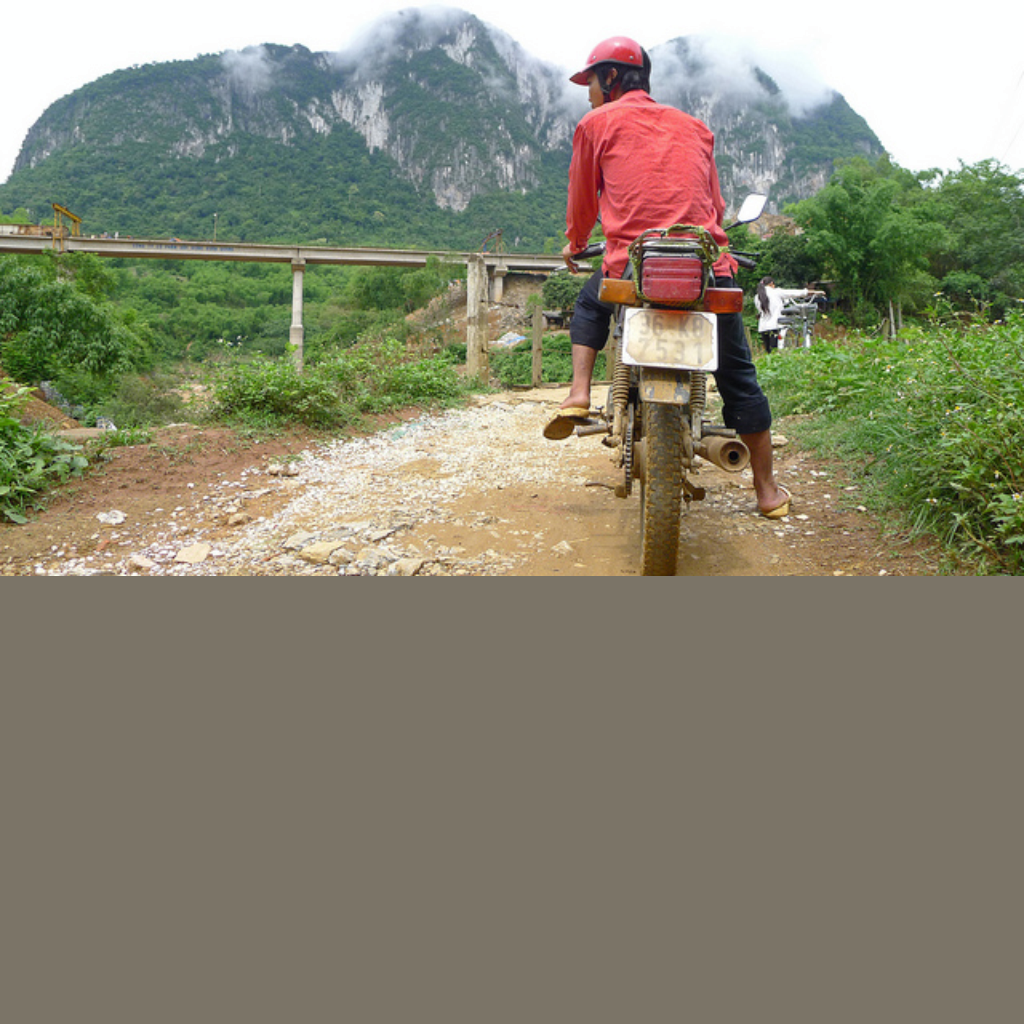

In [21]:
get_image(sample["images"][0])

0
person, bicycle, motorcycle


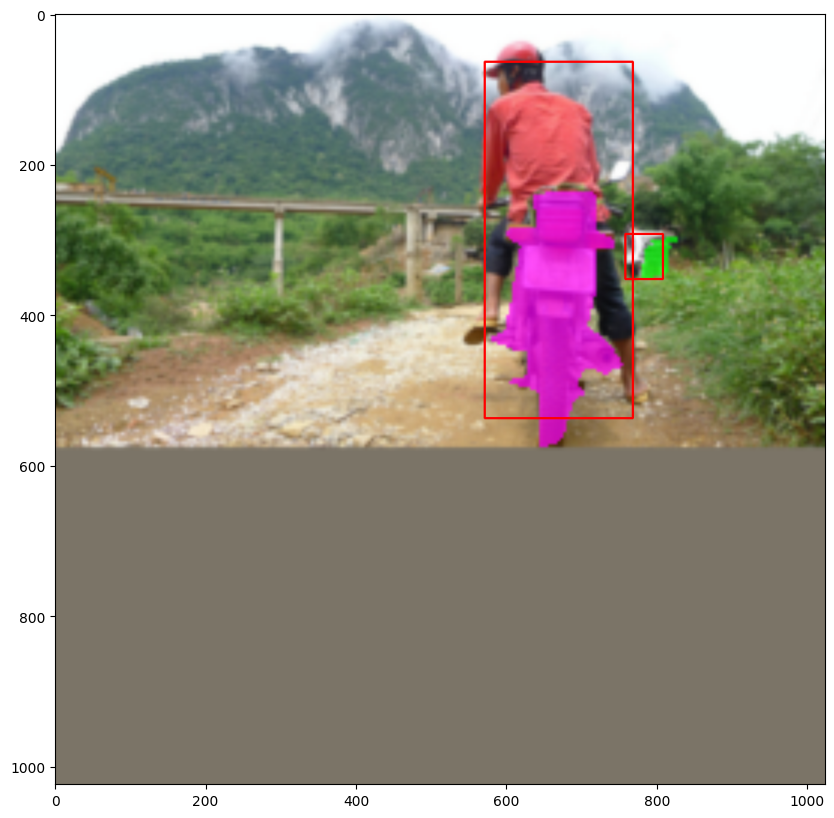

1
bicycle, bench


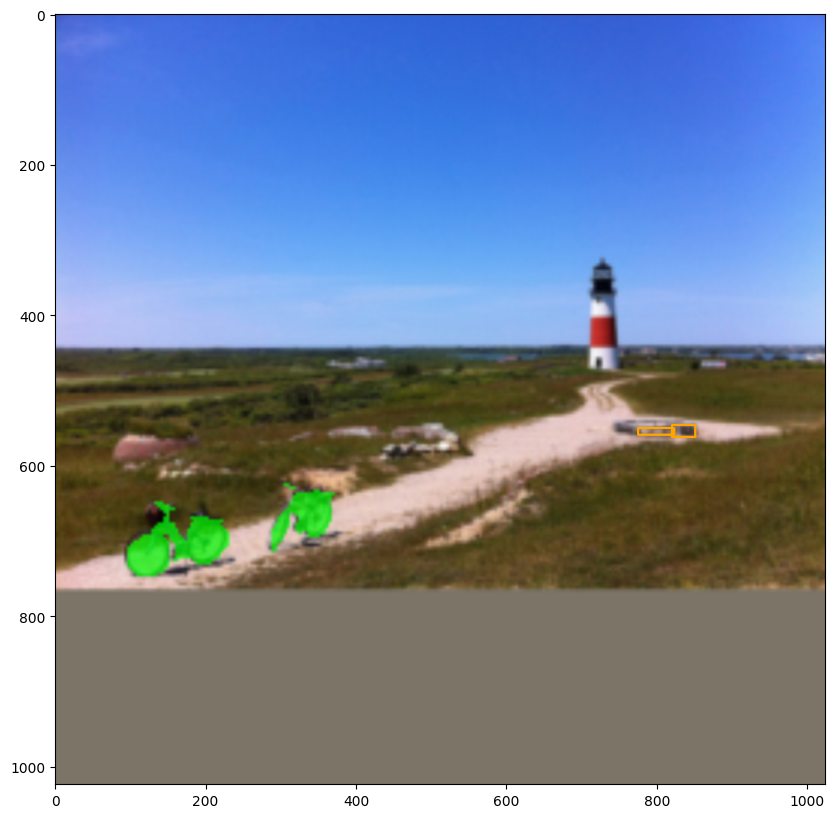

2
person, car, motorcycle, truck, dog


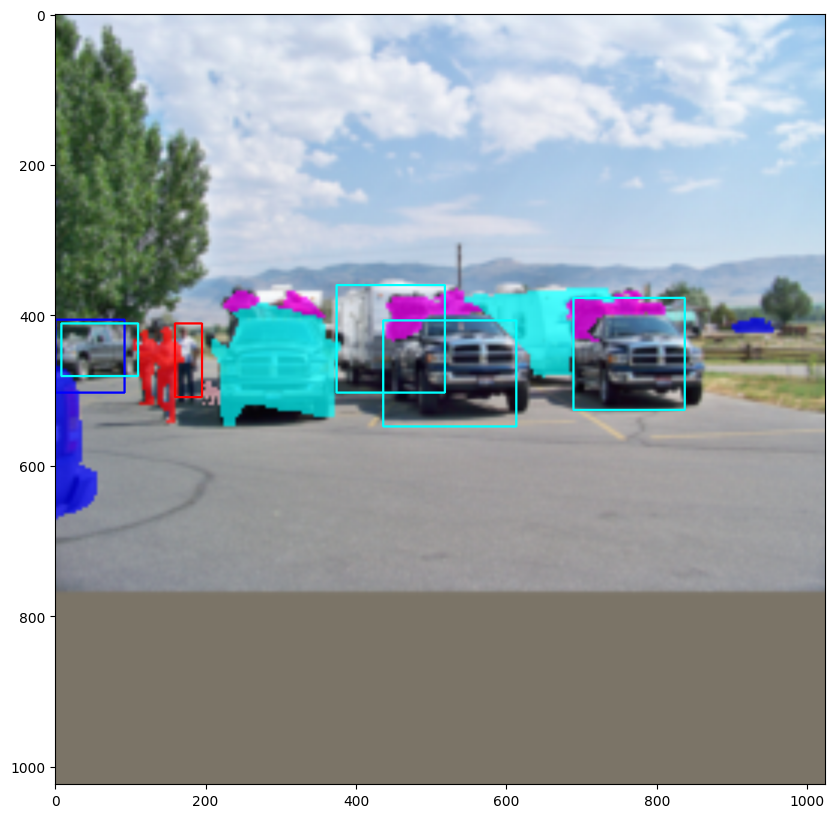

In [22]:
# show examples one by one
for i, example in enumerate(images):
    cats = [dataset.categories["coco"][cat]["name"] for cat in sample["classes"][i]]
    print(i)
    print(", ".join(cats))
    plt.figure(figsize=(10, 10))
    plt.imshow(example)
    plt.show()

In [23]:
sample["prompt_bboxes"].shape, sample["flag_bboxes"].shape
# drop last dimension of sample["prompt_bboxes"] and replace with the sum

def test_flag_bboxes(sample):
    prompt_bboxes_sum = sample["prompt_bboxes"].sum(dim=-1)
    # replace positive values with 1
    prompt_bboxes_sum = torch.where(prompt_bboxes_sum > 0, torch.tensor(1), torch.tensor(0))
    assert torch.all(torch.eq(prompt_bboxes_sum, sample["flag_bboxes"]))

test_flag_bboxes(sample)

In [24]:
def test_flag_coords(sample):
    prompt_coords_sum = sample["prompt_points"].sum(dim=-1)
    # replace positive values with 1
    prompt_coords_sum = torch.where(prompt_coords_sum > 0, torch.tensor(1), torch.tensor(0))
    assert torch.all(torch.eq(prompt_coords_sum, sample["flag_points"]))

test_flag_coords(sample)

In [25]:
def test_flag_masks(sample):
    prompt_masks_sum = sample["prompt_masks"].sum(dim=(-2, -1))
    prompt_masks_sum = torch.where(prompt_masks_sum > 0, torch.tensor(1), torch.tensor(0))
    assert torch.all(torch.eq(prompt_masks_sum, sample["flag_masks"]))

test_flag_masks(sample)

In [26]:
batch["prompt_masks"].shape, batch["flag_masks"].shape

(torch.Size([8, 3, 15, 256, 256]), torch.Size([8, 3, 15]))

In [27]:
test_flag_masks(batch)

In [28]:
sample["prompt_points"]

tensor[3, 15, 0, 2] n=0 empty

In [33]:
from tqdm import tqdm
dataset.num_examples = 2

for (batch, gt), _ in tqdm(dataloader):
    test_flag_bboxes(batch)
    test_flag_coords(batch)
    test_flag_masks(batch)

  0%|          | 16/15597 [00:12<3:22:19,  1.28it/s]


KeyboardInterrupt: 

In [ ]:
with open(RAW_DATA_DIR / "annotations" / "instances_train2017.json") as f:
    data = json.load(f)

In [ ]:
id2img = {img["id"]: img for img in data["images"]}

In [ ]:
id2img[262284]

In [ ]:
annotations = data["annotations"]

In [ ]:
print(len(annotations))

In [ ]:
annotations[0]

In [ ]:
for ann in annotations:
    if ann["image_id"] == 262284:
        print(ann)